In [1]:
from skimage.io import imread
from skimage.measure import regionprops
from skimage.morphology import remove_small_objects
%matplotlib notebook
import matplotlib.pyplot as plt
from utils.multi_slice_viewer import multi_slice_viewer
import os
import numpy as np
from scipy.spatial import Delaunay, Voronoi
import pandas as pd
from skimage.measure import regionprops_table

### Primary functions

#### Shape based feature extractor. This is the primary feature extractor used to grab geometric features from segmented nuclei. The properties from each labeled nuclei is output as a pandas dataframe for convenience. 

In [2]:


def getObjectProperties(labeled_image):
    
    """
    Returns labeled object properties in a pandas DataFrame for convienient sorting.
    
    
    Parameters 
    ----------
    
    labled_image : 3D numpy array
        Segmented image of nuclei where each individual object has been assigned a 
        unique integer idea.
        
    
    Returns
    -------
    
    object_props : pd.DataFrame
        DataFrame object with selected properties extracted using skimage.measure.regionprops_table
    
    
    
    """
    
    #object properties for extraction
    properties=[ 'equivalent_diameter', 'inertia_tensor',
                'inertia_tensor_eigvals', 'major_axis_length',
                'minor_axis_length', 'moments',
                'moments_central', 'label', 'area',
                'solidity', 'feret_diameter_max',
                'moments_normalized', 'centroid', 'bbox']
    
    #extract features and return as dataframe
    object_props = pd.DataFrame(regionprops_table(labeled_image,properties=properties))
    return object_props

#### Centroid reorganization - graph based features are constructed using a set of nodes, in this case the centroids of segmented nuclei. This method reorganizes the centroids and labels extracted from the above method into a 4D array. The array is the entire set of 3D points corresponding to centroid location of segmented nuclei in the labeled image. 

In [3]:
def getCentroids(proptable):
    
    """
    Returns labeled object centroids and labels in a dictionary.
    
    
    Parameters 
    ----------
    
    proptable : pd.DataFrame
        labeled object properties with centroid & label columns
    
    
    Returns
    -------
    
    props_dict : dict
        Dictionary with 'centroids' and 'labels' as keys, with corresponding
    centroids and labels extracted from proptable as numpy arrays.
    """
    
    props_dict = {}
    
    #get centroid column titles
    filter_col = [col for col in proptable if col.startswith('centroid')]
    
    props_dict['centroids'] = proptable[filter_col].to_numpy().astype(int)
    props_dict['labels'] = proptable['label'].to_numpy()
    
    return props_dict

#### Graph based feature extraction - the following method extracts graph based features (Delaunay & Voronoi diagrams) using the set of nuclear centroids as the input.

In [4]:

def getTesselations(centroids):
    
    """
    Return two graph based features from the scipy.spatial module
    
    
    Parameters
    ----------
    
    centroids : numpy array
        Array of centroids extracted from segmented nuclei
        
        
    Returns
    -------
    
    tesselD : scipy.spatial.Delaunay
        Fully connected graph based feature where nuclear centroids are
    input as nodes on the graph.
    
    tesselV : scipy.spatial.Voronoi
        Region based graph (derived from Delaunay) where individual regions
    are grown from points i.e nuclear centroids.
    
    """
    
    #extract delaunay diagram from scipy.spatial 
    tesselD = Delaunay(centroids)
    
    #extract voronoi diagram from scipy.spatial
    tesselV = Voronoi(centroids)
    
    return tesselD, tesselV
    

### Load example labeled 3D data from disk

In [5]:
data_file = os.path.join('./data/region1_3D_crop.tif')
data = imread(data_file)

### Display 3D data using multi-slice-viewer (use j & k keys to pan through volume)

<IPython.core.display.Javascript object>


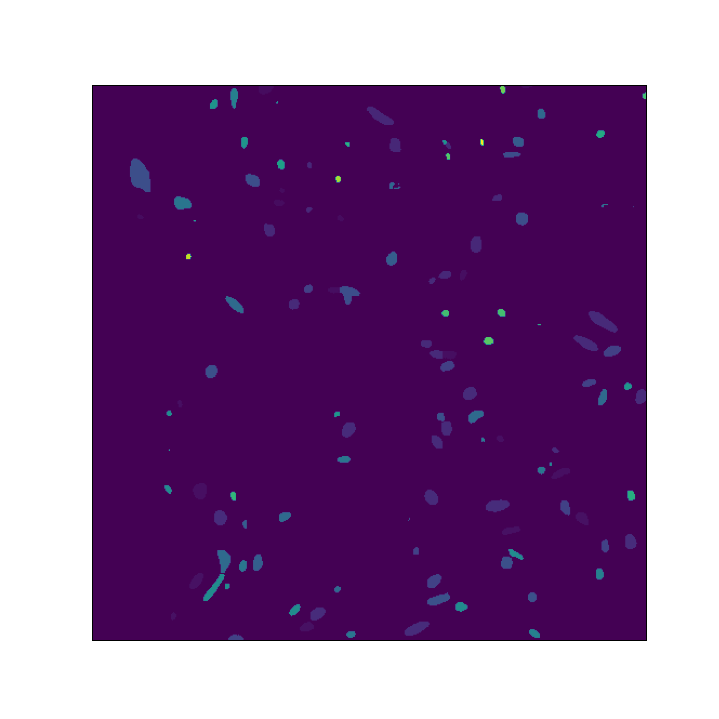

In [6]:
multi_slice_viewer(data, figsize= (8,8))

### Extract shape based features

In [7]:
data = remove_small_objects(data, min_size=100)

properties = getObjectProperties(data)

In [8]:
min(properties['area'])

104

<IPython.core.display.Javascript object>


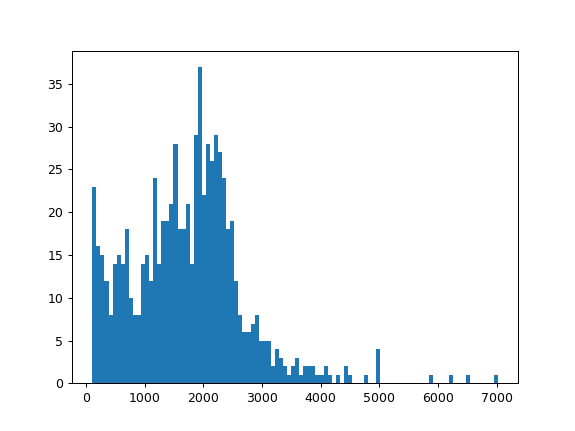

(array([23., 16., 15., 12.,  8., 14., 15., 14., 18., 10.,  8.,  8., 14.,
        15., 12., 24., 14., 19., 19., 21., 28., 18., 18., 21., 14., 29.,
        37., 22., 28., 26., 29., 27., 24., 18., 19., 12.,  8.,  6.,  6.,
         7.,  8.,  5.,  5.,  5.,  2.,  4.,  3.,  2.,  1.,  2.,  3.,  1.,
         2.,  2.,  2.,  1.,  1.,  2.,  1.,  0.,  1.,  0.,  2.,  1.,  0.,
         0.,  0.,  1.,  0.,  0.,  4.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 104.  ,  173.23,  242.46,  311.69,  380.92,  450.15,  519.38,
         588.61,  657.84,  727.07,  796.3 ,  865.53,  934.76, 1003.99,
        1073.22, 1142.45, 1211.68, 1280.91, 1350.14, 1419.37, 1488.6 ,
        1557.83, 1627.06, 1696.29, 1765.52, 1834.75, 1903.98, 1973.21,
        2042.44, 2111.67, 2180.9 , 2250.13, 2319.36, 2388.59, 2457.82,
        2527.05, 2596.28, 2665.51, 2734.74, 2803.97, 2873.2 , 2942.43,
        

In [9]:
plt.subplots()
plt.hist(properties['area'], bins = 100)

### Collect nuclear centroids

In [10]:
centroids = getCentroids(properties)

### Extract graph-based tesselations

In [11]:
tesselD, tesselV = getTesselations(centroids['centroids'])